In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
from math import sqrt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, f1_score, recall_score
import ast

# Load and prepare the ratings data
with open('ratings.py', 'r') as file:
    ratings_content = file.read()
ratings_list = ast.literal_eval(ratings_content.split('=')[1].strip())
ratings_df = pd.DataFrame(ratings_list)

# Split the data into training and testing sets
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Function to prepare data for KNN
def prepare_data_for_knn(data):
    pivot_data = data.pivot(index='product_id', columns='user_id', values='rating').fillna(0)
    matrix_data = csr_matrix(pivot_data.values)
    return pivot_data, matrix_data

train_pivot, train_matrix = prepare_data_for_knn(train_df)
test_pivot, test_matrix = prepare_data_for_knn(test_df)

# Initialize and train the KNN model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(train_matrix)

# Adjusted predict_rating function
def predict_rating_adjusted(user_id, product_id, pivot_data, model, global_avg_rating):
    if user_id in pivot_data.columns and product_id in pivot_data.index:
        user_idx = list(pivot_data.columns).index(user_id)
        product_idx = list(pivot_data.index).index(product_id)
        distances, indices = model.kneighbors(pivot_data.iloc[product_idx, :].values.reshape(1, -1), n_neighbors=7)
        neighbor_ratings = [pivot_data.iloc[indices.flatten()[i], user_idx] for i in range(1, len(distances.flatten())) if pivot_data.iloc[indices.flatten()[i], user_idx] > 0]
        if neighbor_ratings:
            return np.mean(neighbor_ratings)
        else:
            user_avg = pivot_data.iloc[:, user_idx][pivot_data.iloc[:, user_idx] > 0].mean()
            product_avg = pivot_data.iloc[product_idx, :][pivot_data.iloc[product_idx, :] > 0].mean()
            return user_avg if not np.isnan(user_avg) else product_avg if not np.isnan(product_avg) else global_avg_rating
    else:
        return global_avg_rating

# Calculate the global average rating
global_average_rating = train_df['rating'].mean()

# Generating predictions with the adjusted function
test_predictions_adjusted = test_df.apply(lambda x: predict_rating_adjusted(x['user_id'], x['product_id'], train_pivot, knn_model, global_average_rating), axis=1)

# Recalculate evaluation metrics
mse_adjusted = mean_squared_error(test_df['rating'], test_predictions_adjusted)
rmse_adjusted = sqrt(mse_adjusted)
mae_adjusted = mean_absolute_error(test_df['rating'], test_predictions_adjusted)

# Print evaluation metrics
evaluation_metrics_adjusted = {"MSE": mse_adjusted, "RMSE": rmse_adjusted, "MAE": mae_adjusted}
print(evaluation_metrics_adjusted)

threshold = 3  # Ratings above 3 are 'likes', and 3 or below are 'dislikes'

# Function to classify ratings based on the threshold
def classify_ratings(rating, threshold):
    return 1 if rating > threshold else 0  # 1 for 'like', 0 for 'dislike'

# Applying classification to actual and predicted ratings
actual_classes = test_df['rating'].apply(classify_ratings, args=(threshold,))
predicted_classes = test_predictions_adjusted.apply(classify_ratings, args=(threshold,))

# Calculate accuracy, F1 score, and recall
accuracy = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes)
recall = recall_score(actual_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

{'MSE': 2.3052086946467796, 'RMSE': 1.5182913734348817, 'MAE': 1.234543010752688}
Accuracy: 0.75
F1 Score: 0.8571428571428571
Recall: 0.96


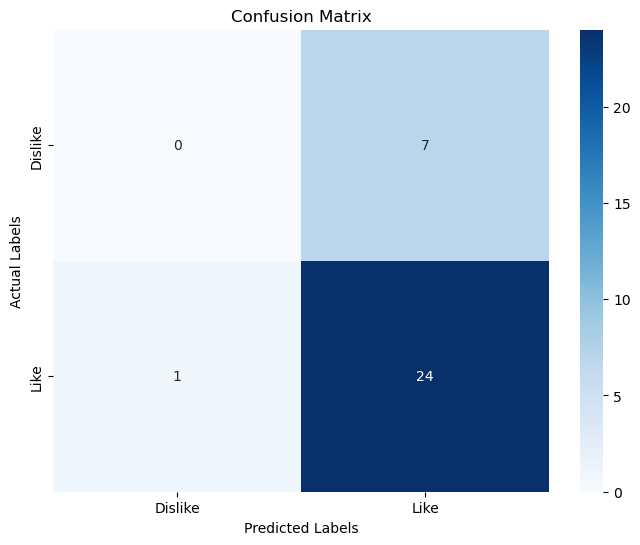

In [3]:
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.xticks(ticks=[0.5, 1.5], labels=['Dislike', 'Like'])
plt.yticks(ticks=[0.5, 1.5], labels=['Dislike', 'Like'])
plt.show()